# USML - Final Project

## Functions

### Data Loaders

In [ ]:
from google.colab import drive
import pandas as pd
import os
import networkx as nx
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community.quality import modularity
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
from sklearn.metrics import silhouette_score

In [ ]:
# mounts google drive and loads CSV file into pandas
def load_data_from_drive(folder_path, file_name):
    drive.mount('/content/drive')

    # file path
    file_path = os.path.join(folder_path, file_name)
    file_extension = os.path.splitext(file_name)[-1].lower()
    # read file
    try:
         if file_extension == '.csv':
            data = pd.read_csv(file_path, delimiter=',')
            return data
         elif file_extension == '.json':
            with open(file_path, 'r') as f:
                data = json.load(f)
            return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return None



### Algorithms

In [ ]:
# Apply the Girvan-Newman algorithm and find the best community division based on modularity
def girvan_newman_algorithm(graph, metrics="modularity", max_num_communities=None):
    removal_order = []
    critical_edges = []
    best_partition = None
    prev_num_communities = len(list(nx.connected_components(graph)))

    if metrics == "modularity":
        modularity_values = []
        best_modularity = -1
        prev_modularity = 0

        while graph.number_of_edges() > 1:
            # Calculate edge betweenness centrality
            edge_betweenness = nx.edge_betweenness_centrality(graph)
            edge_to_remove = max(edge_betweenness, key=edge_betweenness.get)
            graph.remove_edge(*edge_to_remove)
            removal_order.append(edge_to_remove)

            current_communities = list(nx.connected_components(graph))
            current_num_communities = len(current_communities)

            if current_num_communities > prev_num_communities:
                critical_edges.append(edge_to_remove)

            current_modularity = nx.algorithms.community.quality.modularity(graph, [set(c) for c in current_communities])
            modularity_values.append(current_modularity)

            if current_modularity > best_modularity:
                best_modularity = current_modularity
                best_partition = current_communities

            if max_num_communities and current_num_communities > max_num_communities:
                break

            prev_num_communities = current_num_communities

        return removal_order, modularity_values, best_modularity, best_partition, critical_edges

    elif metrics == "silhouette":
        silhouette_scores = []
        best_silhouette = -1
        prev_silhouette = 0

        while graph.number_of_edges() > 1:
            # Calculate edge betweenness centrality
            edge_betweenness = nx.edge_betweenness_centrality(graph)
            edge_to_remove = max(edge_betweenness, key=edge_betweenness.get)
            graph.remove_edge(*edge_to_remove)
            removal_order.append(edge_to_remove)

            current_communities = list(nx.connected_components(graph))
            current_num_communities = len(current_communities)

            if current_num_communities > prev_num_communities:
                critical_edges.append(edge_to_remove)

            current_silhouette = compute_silhouette(graph, [set(c) for c in current_communities])
            silhouette_scores.append(current_silhouette)

            if current_silhouette > best_silhouette:
                best_silhouette = current_silhouette
                best_partition = current_communities


            if max_num_communities and current_num_communities > max_num_communities:
                break

            prev_num_communities = current_num_communities

        return removal_order, silhouette_scores, best_silhouette, best_partition, critical_edges


    else:
        raise ValueError("Invalid metrics. Choose 'modularity' or 'silhouette'.")



def compute_silhouette(graph, communities):
    # Convert graph to adjacency matrix
    adjacency_matrix = nx.to_numpy_array(graph)

    # Assign cluster labels for each node
    labels = np.zeros(len(graph.nodes))
    for i, community in enumerate(communities):
        for node in community:
            labels[node] = i

    # Calculate shortest path distance matrix
    sp_lengths = dict(nx.all_pairs_shortest_path_length(graph))
    distance_matrix = np.zeros((len(graph.nodes), len(graph.nodes)))
    for i, lengths in sp_lengths.items():
        for j, length in lengths.items():
            distance_matrix[i, j] = length

    # Compute Silhouette score
    silhouette_avg = silhouette_score(distance_matrix, labels, metric="precomputed")
    return silhouette_avg


### Visulization Methods

In [ ]:
def visualize_graph(graph):
    plt.figure(figsize=(10, 8))
    plt.title("Graph without Node Labels")
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph,
            pos,
            with_labels=False,
            node_color="blue",
            edge_color="gray",
            node_size=15,
            alpha=0.6,
            width=0.7,)
    plt.show()


# Visualize the communities in a graph
def visualize_communities(graph, partition):
    color_map = {}
    for idx, community in enumerate(partition):
        for node in community:
            color_map[node] = idx

    # Draw graph
    colors = [color_map[node] for node in graph.nodes()]
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph,
            pos,
            node_color=colors,
            with_labels=False,
            edge_color="gray",
            node_size=15,
            alpha=0.6,
            width=0.7,)
    plt.title("Community with Node Color")
    plt.show()


In [ ]:
def plot_metrics_vs_remove(metrics_values, metrics="Modularity"):
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(metrics_values)), metrics_values, marker='o', linestyle='-')
    plt.xlabel("Number of Removing Edges")
    plt.ylabel(f"Best {metrics}")
    plt.title(f"Maximized {metrics} vs Removing Edges")
    plt.grid()
    plt.show()

def plot_dendrogram_from_reverse(graph, removal_order, critical_edges, best_partition):
    import numpy as np
    from scipy.cluster.hierarchy import dendrogram
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

    merges = []
    cluster_mapping = {node: node for node in graph.nodes()}
    current_cluster_id = graph.number_of_nodes()
    merge_count = 0

    for edge in reversed(removal_order):
        graph.add_edge(*edge)
        if edge in critical_edges:

            cluster1 = cluster_mapping[edge[0]]
            cluster2 = cluster_mapping[edge[1]]


            if cluster1 > cluster2:
                cluster1, cluster2 = cluster2, cluster1


            merges.append([cluster1, cluster2, merge_count, 2])
            merge_count += 1


            for node, cluster in cluster_mapping.items():
                if cluster == cluster1 or cluster == cluster2:
                    cluster_mapping[node] = current_cluster_id
            current_cluster_id += 1


    merges_array = np.array(merges, dtype=float)


    plt.figure(figsize=(10, 6))
    dendro = dendrogram(
        merges_array,
        labels=range(graph.number_of_nodes()),
        color_threshold=0,
        orientation='top',
    )

    plt.title("Number of Merges vs. Node Communities")
    plt.xlabel("Nodes")
    plt.ylabel("Number of Merges")
    plt.tight_layout()
    plt.show()

def plot_degree_distribution(G_sub):
    """
    Plot the degree distribution of the graph to observe if there are hubs (power-law distribution).

    Parameters:
    - G_sub: The subgraph to analyze (NetworkX Graph object).
    """
    # Get degree distribution
    degrees = [deg for node, deg in G_sub.degree()]

    # Plot degree distribution
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Degree Distribution", fontsize=16)
    plt.xlabel("Degree (Number of Connections)", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.show()



### Utils

In [ ]:
# Sample a subgraph by selecting nodes with degree >= min_degree
# def sample_graph_by_degree(graph, min_degree):
#     nodes_to_keep = [node for node, degree in graph.degree() if degree >= min_degree]
#     subgraph = graph.subgraph(nodes_to_keep).copy()
#     return subgraph

# Sample a subgraph by selecting nodes with degree >= min_degree and keep their neighbors
def sample_graph_by_degree(graph, min_degree, min_neighbor_degree):
    primary_nodes = {node for node, degree in graph.degree() if degree >= min_degree}

    neighbors = set()
    for node in primary_nodes:
        for neighbor in graph.neighbors(node):
            if graph.degree[neighbor] >= min_neighbor_degree:
                neighbors.add(neighbor)

    nodes_to_keep = primary_nodes.union(neighbors)
    subgraph = graph.subgraph(nodes_to_keep).copy()
    return subgraph

# Sample a subgraph by randomly selecting a subset of nodes
def sample_graph_by_nodes(graph, sample_size):
    sampled_nodes = random.sample(graph.nodes(), min(sample_size, len(graph)))
    # Create a subgraph
    subgraph = graph.subgraph(sampled_nodes).copy()
    return subgraph


def remove_small_components(graph, min_size):
    components = list(nx.connected_components(graph))
    large_components = [comp for comp in components if len(comp) >= min_size]
    nodes_to_keep = set().union(*large_components)
    return graph.subgraph(nodes_to_keep).copy()

In [ ]:
# Find the most frequent page_type in each community
def find_dominant_page_type(label_data, best_partition):
    # Create a mapping from node ID to page_type
    id_to_page_type = dict(zip(label_data['id'], label_data['page_type']))

    # Store results
    dominant_page_types = {}

    for idx, community in enumerate(best_partition):
        # Collect all page_types in the community
        page_types = [id_to_page_type[node] for node in community if node in id_to_page_type]

        # Count the occurrences of each page_type
        type_counter = Counter(page_types)

        # Find the most common page_type
        if type_counter:
            most_common_type, count = type_counter.most_common(1)[0]
            dominant_page_types[idx] = {'page_type': most_common_type, 'count': count}
        else:
            dominant_page_types[idx] = {'page_type': None, 'count': 0}

    return dominant_page_types


## Problem 1

### Pre-Processing and visulization

In [ ]:
FOLDER_PATH = '/content/drive/MyDrive/USML Final Project/facebook_large'
deges_file = 'musae_facebook_edges.csv'
full_data = load_data_from_drive(FOLDER_PATH, deges_file)
print(full_data.head)
full_graph = nx.from_pandas_edgelist(full_data, 'id_1', 'id_2', create_using=nx.Graph())
print(full_graph)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<bound method NDFrame.head of          id_1   id_2
0           0  18427
1           1  21708
2           1  22208
3           1  22171
4           1   6829
...       ...    ...
170997  20188  20188
170998  22340  22383
170999  22348  22348
171000   5563   5563
171001  22425  22425

[171002 rows x 2 columns]>
Graph with 22470 nodes and 171002 edges


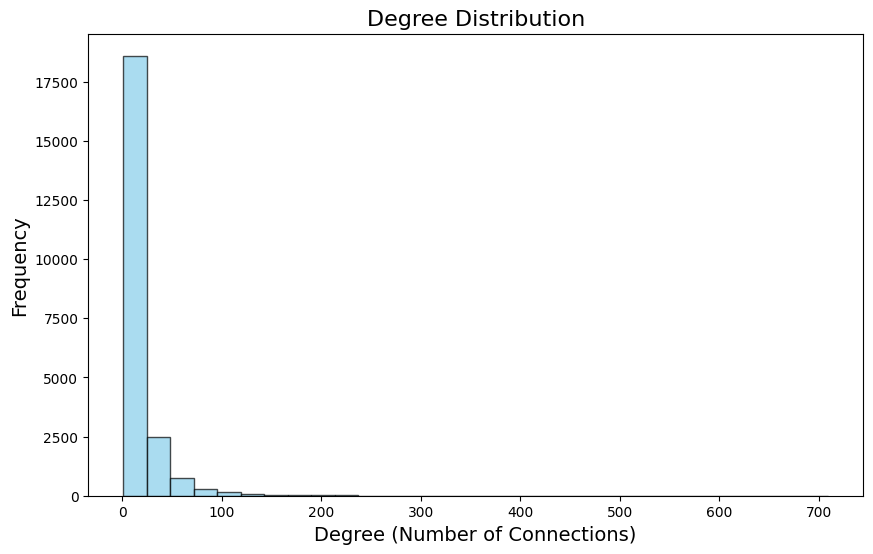

In [ ]:
plot_degree_distribution(full_graph)

In [ ]:
label_data = load_data_from_drive(FOLDER_PATH, 'musae_facebook_target.csv')
print(label_data.head)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<bound method NDFrame.head of           id       facebook_id                                     page_name  \
0          0   145647315578475                      The Voice of China 中国好声音   
1          1      191483281412                 U.S. Consulate General Mumbai   
2          2   144761358898518                                          ESET   
3          3   568700043198473  Consulate General of Switzerland in Montreal   
4          4  1408935539376139             Mark Bailey MP - Labor for Miller   
...      ...               ...                                           ...   
22465  22465  1379955382222841                               Kurt Wiegel MdL   
22466  22466  1651527995097082                                dubdub Stories   
22467  22467   155369444540412            Ministerio del Interior - Paraguay   
22468  22468   175067819212798           

In [ ]:
degree_sampled_graph = sample_graph_by_degree(full_graph, min_degree=100)
print(f"Sampled Graph by degree: {degree_sampled_graph}")

# degree_sampled_graph = sample_graph_by_degree(full_graph, min_degree=100, min_neighbor_degree=100)
# print(f"Sampled Graph by degree: {degree_sampled_graph}")

random_sampled_graph = sample_graph_by_nodes(full_graph, sample_size=1000)
print(f"Sampled Graph by random: {random_sampled_graph}")

Sampled Graph by degree: Graph with 320 nodes and 5785 edges
Sampled Graph by random: Graph with 1000 nodes and 405 edges


<ipython-input-40-a00dad5cb7ef>:23: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(graph.nodes(), min(sample_size, len(graph)))


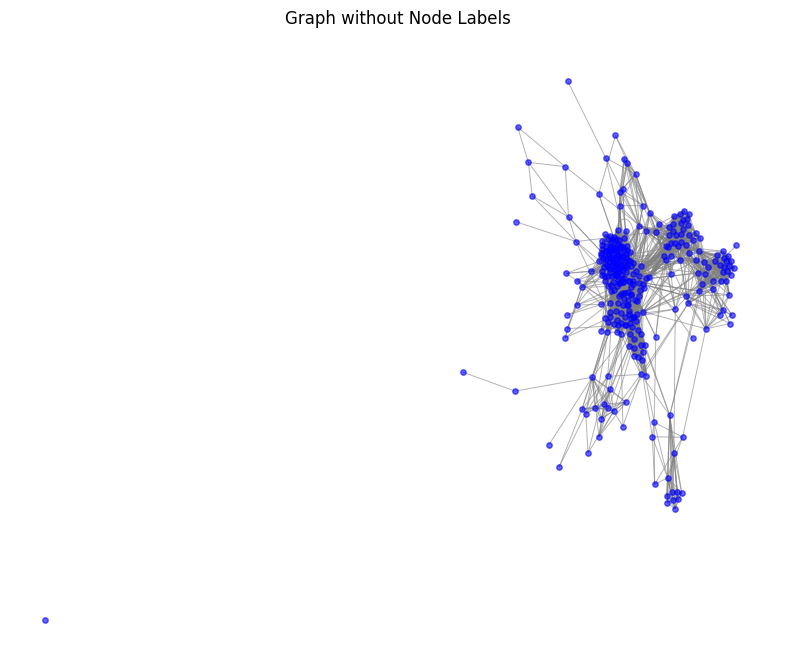

In [ ]:
visualize_graph(degree_sampled_graph)

### Community Detection and Analysis

#### Detect by Modularity

In [ ]:
# run the Girvan-Newman algorithm
graph = degree_sampled_graph.copy()
threshold = int(0.15 * graph.number_of_nodes())
removal_order, modularity_values, best_modularity, best_partition, critical_edges = girvan_newman_algorithm(graph)

# print results
print("Edge removal order:", removal_order)
print("Modularity values:", modularity_values)
print("Best Modularity:", best_modularity)
print("Best Partition:", best_partition)
print("Critical Edges:", critical_edges)


KeyboardInterrupt: 

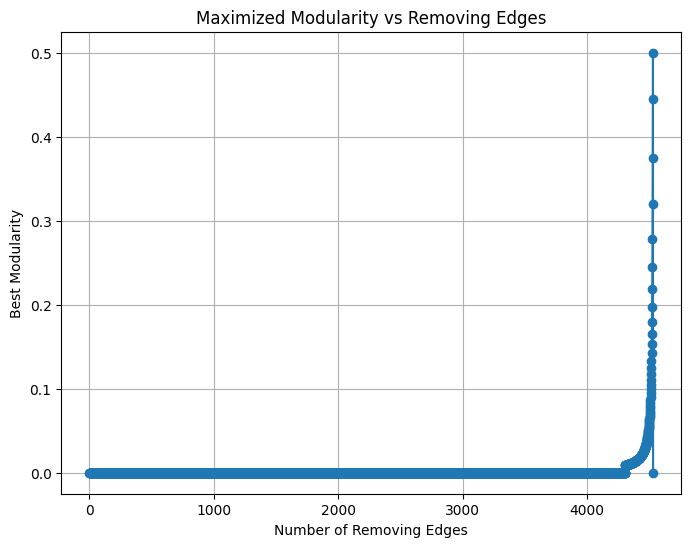

In [ ]:
plot_metrics_vs_remove(modularity_values)

In [ ]:
num_communities = len(best_partition)
size_of_communities = [len(community) for community in best_partition]
dominant_types = find_dominant_page_type(label_data, best_partition)


print(f"Number of communities: {num_communities}")
print(f"Size of communities: {size_of_communities}")
print(f"Best modularity: {best_modularity}")
for community, info in dominant_types.items():
    print(f"Community {community}: Dominant page_type = {info['page_type']} (Count = {info['count']}, Percentage = {info['count']/size_of_communities[community]})")

Number of communities: 186
Size of communities: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Best modularity: 0.5
Community 0: Dominant page_type = government (Count = 1, Percentage = 1.0)
Community 1: Dominant page_type = government (Count = 1, Percentage = 1.0)
Community 2: Dominant page_type = government (Count = 1, Percentage = 1.0)
Community 3: Dominant page_type = government (Count = 1, Percentage = 1.0)
Community 4: Dominant page_type = government (Count = 1, Percentage = 1.

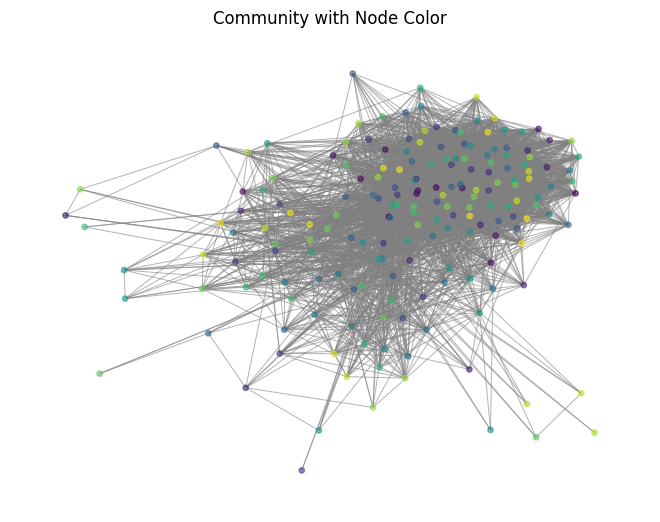

In [ ]:
visualize_communities(degree_sampled_graph, best_partition)

#### Detect by Silhouette

In [ ]:
# run the Girvan-Newman algorithm
graph = degree_sampled_graph.copy()
threshold = int(0.15 * graph.number_of_nodes())
removal_order, silhouette_scores, best_silhouette, best_partition, critical_edges = girvan_newman_algorithm(graph, metrics="silhouette")

# print results
print("Edge removal order:", removal_order)
print("Modularity values:", silhouette_scores)
print("Best Modularity:", best_silhouette)
print("Best Partition:", best_partition)
print("Critical Edges:", critical_edges)

IndexError: index 3584 is out of bounds for axis 0 with size 187

In [ ]:
plot_metrics_vs_remove(silhouette_scores, metrics="Silhouette")

In [ ]:
num_communities = len(best_partition)
size_of_communities = [len(community) for community in best_partition]
dominant_types = find_dominant_page_type(label_data, best_partition)


print(f"Number of communities: {num_communities}")
print(f"Size of communities: {size_of_communities}")
print(f"Best Silhouette: {best_silhouette}")
for community, info in dominant_types.items():
    print(f"Community {community}: Dominant page_type = {info['page_type']} (Count = {info['count']}, Percentage = {info['count']/size_of_communities[community]})")

In [ ]:
visualize_communities(degree_sampled_graph, best_partition)

In [ ]:
# plot_dendrogram_from_reverse(degree_sampled_graph, removal_order, critical_edges, best_partition)